# Allen Majewski 20200107

## Problem Statement

##### Data
	1. NYC taxi trip history data from 2015/01 – 2015/12
	2. Daily weather data from 2015/01 – 2015/12
	3. Public holiday data for the year of 2015

##### Problem
Build an ML model to predict whether each trip has over 20% tip rate or not.

##### Expected outputs

	1. Please submit the code you developed to build predictive model(s) as Jupyter notebook(s) on Python3 kernel.
	2. Please summarize the key conclusion of your analysis. This report should include the following:
		a. The most significant features that affect each trip’s tip percentage.
		b. The performance of your predictive model(s), and suggest what additional dataset you’d like to include to improve the performance of your models.

##### Note
	1.  Please assume the client wants to get the model with high prediction accuracy.
	2.  Please assume the code would be reviewed by your team members, and be further developed.



#  My Approach

I view the problem as *both a regression problem to predict tips, and pure classification problem to categorize the trips* as either having a sufficient tip or not.  The dataset contains both contionuous and discrete variables allowing a hybrid approach.

    1. We can use regression to predict the continuous variable `tip_fraction`

    2. This inherently results in a classififer by simply setting a threshold of 20%, but

    3. This data is also amenable to traditional classification models with the goal to predict whether or not a tip is "good", the boolean variable `tip_is_over_twenty_percent`.

Discussion will follow inline with the code as I work through the dataset and the models.



Notes:

This is a git repository with the following structure:

`README.md`

`src/`

`-- taxitip_model.ipynb` (this file)

`data/`

   `-- 2015_<MM>_100k.csv` 
   
   `-- 2015_weather.csv`
   
   `-- holidays.csv`
   
The data files are in the gitignore so they are not pushed.  The data csv files need to be in the data/ dir for this notebook to work.







In [66]:
import numpy as np
import pandas as pd
import os
import sys
import random
import calendar
import datetime
import matplotlib.pyplot as plt
# from operator import add, truediv
# from collections import OrderedDict
from sklearn import preprocessing
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.naive_bayes import GaussianNB
# from scipy.stats.stats import pearsonr
import calendar
import datetime


# some useful functions for later

def get_min_max(seq,keep_minmax=False):
    '''
    simple min max scaler
    '''
    min_ = min(seq)
    max_ = max(seq)
    seq = (seq-min_)/(max_ - min_)
    if keep_minmax:
        return [(min_,max_),seq]
    else:
        return seq

def lmap(func, alist):
    '''
    returns a list instead of a map object
    '''
    return list(map(func, alist))

def anomaly(seq):
    '''
    statistical anomaly
    '''
    return (seq - np.average(seq))/np.std(seq)



os.chdir('../data')

# 1.  Data Construction

## load up fare data

`bigdf` will eventually contain all the months data plus additional dervied data and weather + holiday data.

We begin by loading the fare data by month.

In [27]:
dfs = []

for infile in sorted([ _ for _ in os.listdir('.') if _.endswith('100k.csv')]):
    sys.stdout.write('\r'+f'loading {infile}')
    df = pd.read_csv(infile)
    dfs.append(df)
    
bigdf = pd.concat(dfs, ignore_index=True)

bigdf.tail(5)

loading 2015-12_100k.csv

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_zip,pickup_borough,pickup_neighborhood,dropoff_zip,dropoff_borough,dropoff_neighborhood
1199995,2,2015-12-16 19:00:26,2015-12-16 19:08:39,2,1.25,-73.974289,40.779854,1,N,-73.975204,...,1.4,0.00,0.3,10.70,10023,Manhattan,Upper West Side,10025,Manhattan,Upper West Side
1199996,1,2015-12-07 06:41:33,2015-12-07 06:45:03,1,0.70,-73.991707,40.749870,1,N,-73.980362,...,0.0,0.00,0.3,5.80,10001,Manhattan,Chelsea and Clinton,10016,Manhattan,Gramercy Park and Murray Hill
1199997,1,2015-12-02 09:18:35,2015-12-02 09:30:59,1,1.40,-73.955223,40.773376,1,N,-73.968201,...,0.0,0.00,0.3,10.30,10028,Manhattan,Upper East Side,10022,Manhattan,Gramercy Park and Murray Hill
1199998,1,2015-12-29 09:02:47,2015-12-29 09:08:49,1,0.60,-73.990509,40.742191,1,N,-73.979141,...,0.0,0.00,0.3,6.30,10010,Manhattan,Gramercy Park and Murray Hill,10010,Manhattan,Gramercy Park and Murray Hill
1199999,2,2015-12-09 21:57:56,2015-12-09 22:18:33,2,10.00,-73.870743,40.773689,1,N,-73.860840,...,0.0,5.54,0.3,36.34,11369,Queens,West Queens,10462,Bronx,Southeast Bronx



## Defining the objective: 20% of what?

We will try to predict the `tip_fraction` using regression, but it must first be defined.

We will consider tips that are 20% of the fare *without taxes*, as discussed with Michal.  Noting that 

$\text{total_amount}$ 

includes tax, tip, and all charges, please take a moment to convince yourself that we must define a new fare variable

$\text{user_fare} = \text{total_amount} - \text{tip_amount} - \text{mta_tax}$

Then tip fraction is just

$\text{tip_fraction} = \text{tip_amount}/\text{user_fare}$



In [28]:
USER_FARE    = np.array(bigdf.total_amount) - np.array(bigdf.tip_amount) - np.array(bigdf.mta_tax)
TIP_FRACTION = np.array(bigdf.tip_amount)/USER_FARE

bigdf['user_fare']    = USER_FARE
bigdf['tip_fraction'] = TIP_FRACTION



We will use regression here to predict the `tip_fraction` and/or tip, but the problem is to *classify* whether the tip is above a threshold (20%).  

Let us then implement this boolean to be predicted by a *classifier*:



`initialize:` 

$\text{tip_over_twenty_percent} \leftarrow 0$.


`if:`

$\text{tip_fraction} \ge 0.2$

`then:`

$\text{tip_over_twenty_percent} \leftarrow 1$



In [29]:
TIP_OVER_TWENTY = [0]*len(bigdf)

for idx, tip_fraction in enumerate(bigdf.tip_fraction.values):
    if tip_fraction >= 0.2:
        TIP_OVER_TWENTY[idx] = 1

bigdf['tip_over_twenty_percent'] = TIP_OVER_TWENTY

bigdf.head(5)

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,total_amount,pickup_zip,pickup_borough,pickup_neighborhood,dropoff_zip,dropoff_borough,dropoff_neighborhood,user_fare,tip_fraction,tip_over_twenty_percent
0,2,2015-01-06 11:39:29,2015-01-06 11:49:15,1,1.78,-73.999619,40.743599,1,N,-73.992203,...,9.80,10011,Manhattan,Chelsea and Clinton,10036,Manhattan,Chelsea and Clinton,9.3,0.000000,0
1,1,2015-01-13 09:18:29,2015-01-13 09:23:40,1,2.10,-73.981956,40.778290,1,N,-73.962173,...,10.75,10023,Manhattan,Upper West Side,10024,Manhattan,Upper West Side,7.8,0.314103,1
2,2,2015-01-16 07:15:44,2015-01-16 07:26:42,1,2.33,-73.991188,40.742226,1,N,-73.981613,...,11.80,10010,Manhattan,Gramercy Park and Murray Hill,10019,Manhattan,Chelsea and Clinton,10.3,0.097087,0
3,1,2015-01-23 11:56:05,2015-01-23 12:13:20,1,2.10,-73.959297,40.763336,1,N,-73.979996,...,13.30,10065,Manhattan,Upper East Side,10023,Manhattan,Upper West Side,12.8,0.000000,0
4,1,2015-01-24 10:11:48,2015-01-24 10:18:32,2,0.90,-73.971832,40.764751,1,N,-73.984047,...,7.30,10065,Manhattan,Upper East Side,10019,Manhattan,Chelsea and Clinton,6.8,0.000000,0


A small test of the above manipulations

In [30]:
TEST_SIZE=5000

for i in range(TEST_SIZE):
    
    row_idx = random.randint(0,len(bigdf))
    sys.stdout.write(f'\rtesting row {row_idx}')

    row                     = bigdf.iloc[row_idx]
    user_fare               = row.user_fare
    tip_amount              = row.tip_amount
    tip_fraction            = row.tip_fraction
    tip_over_twenty_percent = row.tip_over_twenty_percent

    assert(tip_fraction == tip_amount/user_fare)
    
    if tip_fraction < 0.2:
        assert(tip_over_twenty_percent == 0)
    else:
        assert(tip_over_twenty_percent == 1)

testing row 9278638

## Join auxiliary holiday and weather data with principle dataset

The plan to proceed is:

1) First manipulate the weather and holiday dataframes to make useful feature data. 

2) Join with the main dataset contained in `bigdf` on `pickup_date` to create a single dataframe with all data that will go into models.

3) Separate the label/discrete type data from continuous data for regression v.s. strict classification methods.



## load weather data

In [31]:
weather = pd.read_csv('2015_weather.csv', sep=';')
weather.head()

,pickup_date,avg_temp_C,Rain,Fog,Snow
0,01.01.15,1,NaN,NaN,NaN
1,02.01.15,4,NaN,NaN,NaN
2,03.01.15,3,1.0,NaN,1.0
3,04.01.15,9,1.0,NaN,NaN
4,05.01.15,2,NaN,NaN,NaN




### Transforming weather data into features

* impute 0 where NaN is in the Rain, Fog, Snow columns and use directly as feature since it is bool
* consider minmax-scaled temperature in deg C, and also temperature anomaly
* fix weird date format, make like canonical `pickup_date`, `YYYY-MM-DD`


In [32]:
# impute 0 for NaN
for column in ['Rain', 'Fog', 'Snow']:
    weather[column] = lmap(np.nan_to_num, weather[column].values)

# minmax scale temp    
weather['avg_temp_C_scaled'] = get_min_max(weather.avg_temp_C.values)

# anomaly
weather['avg_temp_C_anomaly'] = anomaly(weather.avg_temp_C.values)

# fix funny date
def fixdate(date):
    dd   = date.split('.')[0]
    mm   = date.split('.')[1]
    yyyy = '20'+date.split('.')[2]
    
    return f'{yyyy}-{mm}-{dd}'

weather['pickup_date'] = lmap(fixdate, weather.pickup_date.values)

weather.head()

,pickup_date,avg_temp_C,Rain,Fog,Snow,avg_temp_C_scaled,avg_temp_C_anomaly
0,2015-01-01,1,0.0,0.0,0.0,0.302326,-1.226826
1,2015-01-02,4,0.0,0.0,0.0,0.372093,-0.942334
2,2015-01-03,3,1.0,0.0,1.0,0.348837,-1.037165
3,2015-01-04,9,1.0,0.0,0.0,0.488372,-0.468179
4,2015-01-05,2,0.0,0.0,0.0,0.325581,-1.131996


## load holiday data

In [33]:
holidays = pd.read_csv('holidays.csv', sep=';')
holidays.head(10)

,Date,Holiday
0,01.01.15,New Years Day
1,19.01.15,Martin Luther King Jr. Day
2,12.02.15,Lincoln's Birthday
3,16.02.15,Presidents' Day
4,10.05.15,Mother's Day
5,25.05.15,Memorial Day
6,21.06.15,Father's Day
7,03.07.15,Independence Day (observed)
8,07.09.15,Labor Day
9,12.10.15,Columbus Day


### Plan for transforming holidays/dates into features:

1) fix funny date format to the standard of `pickup_date`, `YYYY-MM-DD`

2) add a boolean  

`is_holiday` 

to the principle data ("bigdf")


3) Add day of the week (perhaps fridays have more generous passengers than mondays)

`weekday` 

which will take values `Monday, Tuesday, Wednesday, ...`


which can be one-hot encoded.

4) Add a boolean

`is_weekend`

to distinguish weekend/weekdays.

5) One-hot encode holidays themselves.



In [34]:
holidays['datetime'] = lmap(fixdate, holidays.Date.values)
holidays['pickup_date'] = [ _.split(' ')[0] for _ in holidays.datetime.values ]
holidays = holidays.drop(columns=['Date', 'datetime'])
holidays

,Holiday,pickup_date
0,New Years Day,2015-01-01
1,Martin Luther King Jr. Day,2015-01-19
2,Lincoln's Birthday,2015-02-12
3,Presidents' Day,2015-02-16
4,Mother's Day,2015-05-10
5,Memorial Day,2015-05-25
6,Father's Day,2015-06-21
7,Independence Day (observed),2015-07-03
8,Labor Day,2015-09-07
9,Columbus Day,2015-10-12


#### add is_holiday to bigdf

In [35]:
# add is_holiday to bigdf
#
is_holiday_dates = holidays.pickup_date.values
#print(is_holiday_dates)

bigdf['pickup_date'] = [ _.split(' ')[0] for _ in bigdf.pickup_datetime.values ]
bigdf['is_holiday'] = [ 1 if day in is_holiday_dates else 0 for day in list(bigdf['pickup_date']) ]


#### join bigdf, weather, holiday on 'pickup_date'

In [36]:
bigdf = bigdf.merge(holidays, how='outer', on='pickup_date')
bigdf = bigdf.merge(weather, how='outer', on='pickup_date')

# lets look at christmas day
bigdf[bigdf.pickup_date=='2015-12-25']

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,tip_over_twenty_percent,pickup_date,is_holiday,Holiday,avg_temp_C,Rain,Fog,Snow,avg_temp_C_scaled,avg_temp_C_anomaly
1198349,2,2015-12-25 16:27:44,2015-12-25 16:35:56,1,2.50,-73.987289,40.770222,1,N,-73.957420,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198350,1,2015-12-25 12:24:49,2015-12-25 12:26:46,1,0.80,-73.947639,40.787636,1,N,-73.939316,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198351,1,2015-12-25 19:45:29,2015-12-25 19:49:46,1,1.00,-73.933418,40.763176,1,N,-73.945854,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198352,1,2015-12-25 17:09:49,2015-12-25 17:16:09,1,1.90,-73.974541,40.757076,1,N,-73.989700,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1198353,1,2015-12-25 16:58:52,2015-12-25 17:13:10,2,1.80,-73.984985,40.748184,1,N,-73.982368,...,0,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,2,2015-12-25 23:10:23,2015-12-25 23:18:09,6,1.90,-73.979012,40.785275,1,N,-73.982971,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1199996,2,2015-12-25 09:48:10,2015-12-25 09:56:42,1,1.81,-73.955025,40.769787,1,N,-73.978012,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1199997,1,2015-12-25 14:39:38,2015-12-25 15:01:38,1,9.50,-73.873070,40.774132,1,N,-73.979591,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468
1199998,2,2015-12-25 16:05:09,2015-12-25 16:09:12,1,1.10,-73.988861,40.773930,1,N,-73.999367,...,1,2015-12-25,1,Christmas Day,17,1.0,0.0,0.0,0.674419,0.290468


#### add weekday (monday-friday) and is_weekend

* perhaps folks are grumpy on monday and generous on friday

* weekend != workdays, maybe family outings arent the same as business travel

* let us keep also the hour from the datetime.  (Maybe night travelers are drunk and generous, etc).

In [37]:
def pickup_date_to_weekday(input_string):
    '''
    > pickup_date_to_weekday('2015-12-26')
    'Saturday'
    '''
    inp = input_string.strip()
    yyyy = int(inp.split('-')[0])
    mm   = int(inp.split('-')[1])
    dd   = int(inp.split('-')[2])
    
    return datetime.datetime(yyyy,mm,dd).strftime('%A')


def get_is_weekend(input_weekday):
    if input_weekday in ['Saturday', 'Sunday']:
        return 1
    return 0

def get_hour_of_the_day(input_datetime):
    return int(input_datetime.split(' ')[1].split(':')[0])
    
    
bigdf['weekday']    = lmap(pickup_date_to_weekday, bigdf.pickup_date.values)
bigdf['is_weekend'] = lmap(get_is_weekend, bigdf.weekday.values)
bigdf['pickup_hour']= lmap(get_hour_of_the_day, bigdf.pickup_datetime)

bigdf[bigdf.weekday=='Monday'].head(5)

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,Holiday,avg_temp_C,Rain,Fog,Snow,avg_temp_C_scaled,avg_temp_C_anomaly,weekday,is_weekend,pickup_hour
29934,1,2015-01-19 21:32:14,2015-01-19 21:38:41,1,1.10,-73.938889,40.804935,1,N,-73.955513,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,21
29935,2,2015-01-19 10:33:28,2015-01-19 10:37:56,2,0.74,-73.989578,40.756306,1,N,-74.000748,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,10
29936,2,2015-01-19 12:58:06,2015-01-19 13:01:19,5,1.06,-73.957977,40.773483,1,N,-73.955307,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,12
29937,1,2015-01-19 15:47:08,2015-01-19 15:58:15,2,2.40,-73.995155,40.725227,1,N,-73.992134,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,15
29938,2,2015-01-19 12:09:32,2015-01-19 12:13:19,1,0.93,-74.006767,40.744354,1,N,-73.994789,...,Martin Luther King Jr. Day,4,0.0,0.0,0.0,0.372093,-0.942334,Monday,0,12


Sanity check some lengths.  There should be about as many mondays as thursdays, etc.

In [38]:
for weekday in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    print(weekday, len(bigdf[bigdf.weekday==weekday]))

Monday 153059
Tuesday 165649
Wednesday 174638
Thursday 179529
Friday 180776
Saturday 185746
Sunday 160603


### categorize variables as continuous or discrete

* cts variables useful for regression
* discrete/label to be one-hot-encoded

* first, split bigdf into two X-dataframes for
    1) labels
    2) continuous vars
* get Y-dataframe (vars to be predicted)

In [39]:
# lets give an explicit row index R_ID 
# before we split up the bigdf
# since I don't trust pandas indexes

bigdf['R_ID'] = range(len(bigdf))
print(bigdf.columns)

#lets save this dataframe just in case
print('saving to ',os.getcwd()+'/bigdf.pkl')
bigdf.to_pickle('bigdf.pkl')

Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_zip',
       'pickup_borough', 'pickup_neighborhood', 'dropoff_zip',
       'dropoff_borough', 'dropoff_neighborhood', 'user_fare', 'tip_fraction',
       'tip_over_twenty_percent', 'pickup_date', 'is_holiday', 'Holiday',
       'avg_temp_C', 'Rain', 'Fog', 'Snow', 'avg_temp_C_scaled',
       'avg_temp_C_anomaly', 'weekday', 'is_weekend', 'pickup_hour', 'R_ID'],
      dtype='object')
saving to  /Users/altoidnerd/Desktop/clo/dotdata/data/bigdf.pkl


In [40]:
bigdf.avg_temp_C_anomaly

0         -1.890643
1         -1.890643
2         -1.890643
3         -1.890643
4         -1.890643
             ...   
1199995    0.290468
1199996    0.290468
1199997    0.290468
1199998    0.290468
1199999    0.290468
Name: avg_temp_C_anomaly, Length: 1200000, dtype: float64

In [54]:
# intentionally keep R_ID around in all three?
# ... might be handy


label_X_vars = ['VendorID', 
                'passenger_count', 
                'RateCodeID', 
                'store_and_fwd_flag', 
                'payment_type', 
                'extra',
                'mta_tax',
                'improvement_surcharge',
                'pickup_zip', 
                'pickup_borough', 
                'pickup_neighborhood', 
                'dropoff_zip', 
                'dropoff_borough', 
                'dropoff_neighborhood', 
                'is_holiday', 
                'Holiday', 
                'Rain', 
                'Fog', 
                'Snow', 
                'weekday', 
                'is_weekend', 
                'pickup_hour']

# continuous_X_vars = [ col for col in bigdf.columns if col not in label_X_vars ] 

continuous_X_vars = [#'pickup_datetime',               # we will use pickup_hour
#                    'dropoff_datetime',               # we will use pickup_hour
                     'trip_distance',
                     'pickup_longitude',
                     'pickup_latitude',
                     'dropoff_longitude',
                     'dropoff_latitude',
                     'fare_amount',
#                      'extra',                        # to labels
#                      'mta_tax',                      # to labels
#                      'tip_amount',
                     'tolls_amount',
#                      'improvement_surcharge',        # to labels
                     'total_amount',                   # <--these two may
                     'user_fare',                      # <--correlate
                     'tip_fraction',                   # to be predicted, not a variable; only for visualization
                     'tip_over_twenty_percent',        # to be predicted, not a variable; only for visualization
#                      'pickup_date',                  # deemed irrelevant
#                      'avg_temp_C',                   # use scaled, anomaly
#                      'avg_temp_C_scaled',            # scaled and anomaly have been found to be redundant - ask Allen why
                     'avg_temp_C_anomaly']

Y_vars = ['tip_fraction', 'tip_over_twenty_percent']

# The Holiday column had some NaN's (Christmas, MLK, NaN if not a holiday)
label_X_df = bigdf[label_X_vars]
label_X_df['Holiday'] = label_X_df['Holiday'].fillna('None')
continuous_X_df = bigdf[continuous_X_vars]
Y_df = bigdf[Y_vars]

/Users/altoidnerd/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Small test to see how many values can be taken by the variables

Some notable results below:

* There are more zip codes than possible values for temperature, temperature anomaly
* There are more dropoff zips than pickup zips.  Why?

In [42]:
print('Continuous Variables')
print('variable','num_vals_taken')
for _ in continuous_X_vars:
    print(_,len(set(bigdf[_])))
    
print('\nDiscrete Variables')
print('variable','num_vals_taken')
for _ in label_X_vars:
    print(_,len(set(bigdf[_])))

Continuous Variables
variable num_vals_taken
trip_distance 2179
pickup_longitude 18930
pickup_latitude 40651
dropoff_longitude 25919
dropoff_latitude 55852
fare_amount 327
tolls_amount 131
total_amount 4300
user_fare 1474
avg_temp_C_anomaly 44

Discrete Variables
variable num_vals_taken
VendorID 2
passenger_count 8
RateCodeID 7
store_and_fwd_flag 2
payment_type 4
extra 10
mta_tax 2
improvement_surcharge 2
pickup_zip 163
pickup_borough 5
pickup_neighborhood 40
dropoff_zip 177
dropoff_borough 5
dropoff_neighborhood 42
is_holiday 2
Holiday 15
Rain 2
Fog 2
Snow 2
weekday 7
is_weekend 2
pickup_hour 24


# 2.  Data investigation

Goals:

1) Determine which input variables correlate with one another

2) Determine which input variables correlate individually with the predicted variable `tip_fraction`

## Determination of correlated continuous variables

We will gradually add more to the scatterplots to understand the correlations in the input variables, and those correlartions to the predicted variable, the `tip_fraction`.


* I suspect the following may deomstrate correlations

```
fields =   ['fare_amount',
            'tolls_amount',
            'total_amount',
            'user_fare',
            'tip_fraction']

```


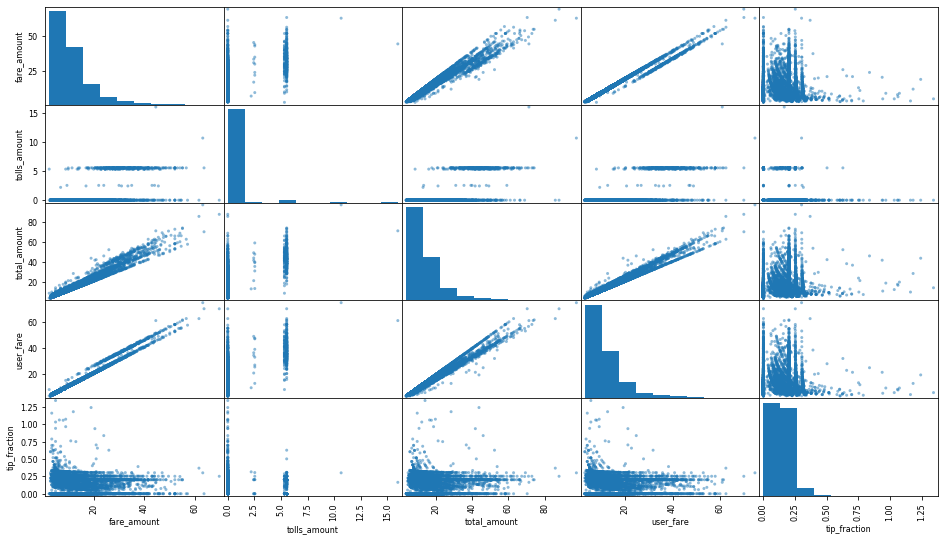

In [64]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

fields =   ['fare_amount',
            'tolls_amount',
            'total_amount',
            'user_fare',
            'tip_fraction']

pd.plotting.scatter_matrix(continuous_X_df[fields].sample(frac=0.01))

# plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(16, 9)
fig.savefig('../figs/continuous_vars_fares.png', format='png', dpi=300)

#### We see that:

1) `user_fare`, `fare_amount`, and `total_amount` are highly correlated.

2) `tip_fraction` depedends categorically on `tolls_amount`.  This is likely due to a few different kinds of trips: e.g., between NY/NJ, inside NY, inside NJ, etc.

3) `tip_fraction` demonstrates complex dependence on the fares.







#### Now let's look at lat-lons with the independent fare and temperature anomaly:

```
fields =   ['trip_distance', 
            'pickup_longitude', 
            'pickup_latitude', 
            'dropoff_longitude', 
            'dropoff_latitude', 
            #'fare_amount', 
            'tolls_amount', 
            #'total_amount', 
            'user_fare', 
            'avg_temp_C_anomaly']

```



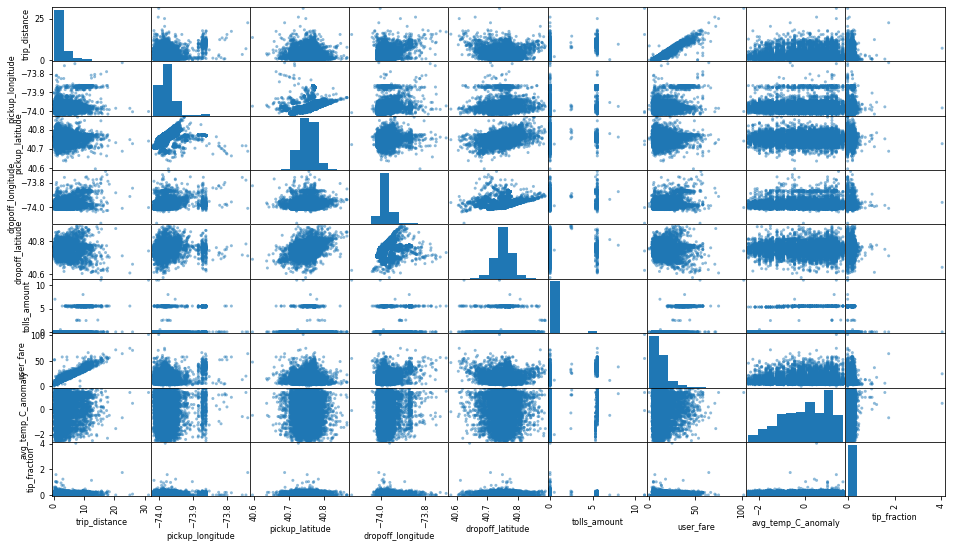

In [65]:
# here try to plot all fields in contonuous_X_df

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fields =   ['trip_distance', 
            'pickup_longitude', 
            'pickup_latitude', 
            'dropoff_longitude', 
            'dropoff_latitude', 
            #'fare_amount', 
            'tolls_amount', 
            #'total_amount', 
            'user_fare', 
            'avg_temp_C_anomaly',
            'tip_fraction']

pd.plotting.scatter_matrix(continuous_X_df[fields].sample(frac=0.01))




fig = plt.gcf()
fig.set_size_inches(16, 9)
fig.savefig('../figs/continuous_vars_latlons.png', format='png', dpi=300)

#### Now lets try to visualize all correlations among continuous variables + tip_fraction

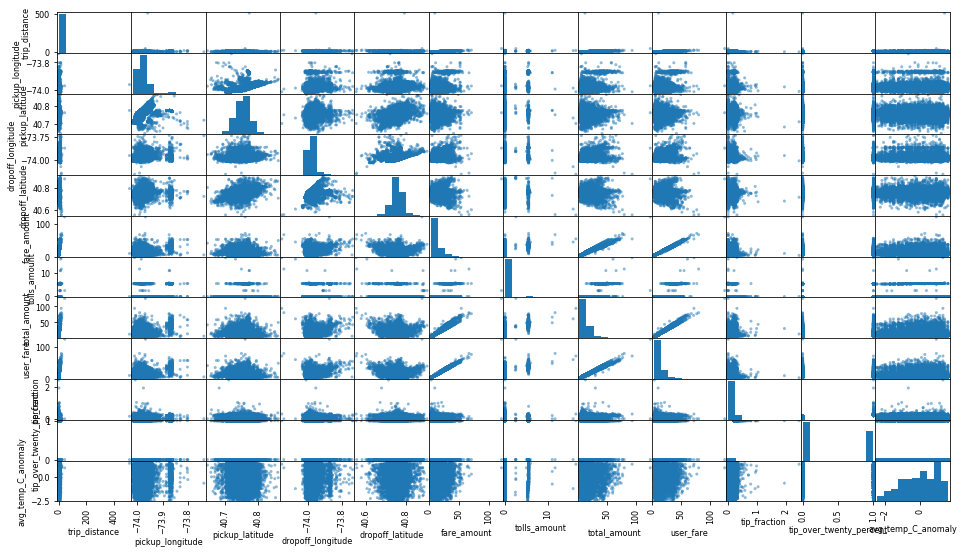

In [63]:
# here try to plot all fields in contonuous_X_df

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



pd.plotting.scatter_matrix(continuous_X_df.sample(frac=0.01))




fig = plt.gcf()
fig.set_size_inches(16, 9)
fig.savefig('../figs/continuous_vars_all.png', format='png', dpi=300)

The scattermatrix plots have informed that some input variables (fare related) are so highly correlated they may be removed from a regression model.  There does not seem to be much correlation between geographic params (latlons to fares, tip_fraction).

# 3.   Models

In [ ]:
Y_df.head()

In [33]:
label_X_df.head()

,VendorID,passenger_count,RateCodeID,store_and_fwd_flag,payment_type,pickup_zip,pickup_borough,pickup_neighborhood,dropoff_zip,dropoff_borough,dropoff_neighborhood,is_holiday,Holiday,Rain,Fog,Snow,weekday,is_weekend,pickup_hour
0,2,1,1,N,2,10011,Manhattan,Chelsea and Clinton,10036,Manhattan,Chelsea and Clinton,0,None,0.0,0.0,1.0,Tuesday,0,11
1,1,1,1,Y,2,10065,Manhattan,Upper East Side,10025,Manhattan,Upper West Side,0,None,0.0,0.0,1.0,Tuesday,0,14
2,1,1,1,N,2,10011,Manhattan,Chelsea and Clinton,10018,Manhattan,Chelsea and Clinton,0,None,0.0,0.0,1.0,Tuesday,0,17
3,1,1,1,N,1,10128,Manhattan,Upper East Side,10021,Manhattan,Upper East Side,0,None,0.0,0.0,1.0,Tuesday,0,8
4,1,2,1,N,1,10128,Manhattan,Upper East Side,10023,Manhattan,Upper West Side,0,None,0.0,0.0,1.0,Tuesday,0,15


In [26]:
 testcols=['VendorID', 'passenger_count', 'RateCodeID', 'store_and_fwd_flag',
        'payment_type', 'pickup_zip', 'pickup_borough', 'pickup_neighborhood',
        'dropoff_zip', 'dropoff_borough', 'dropoff_neighborhood',
        'Holiday', 'weekday']

In [34]:
le = preprocessing.LabelEncoder()



# testdf = label_X_df[testcols]
# test2df = testdf.apply(le.fit_transform)
# test2df.head()

label_X2_df = label_X_df.apply(le.fit_transform)
label_X2_df.head()

,VendorID,passenger_count,RateCodeID,store_and_fwd_flag,payment_type,pickup_zip,pickup_borough,pickup_neighborhood,dropoff_zip,dropoff_borough,dropoff_neighborhood,is_holiday,Holiday,Rain,Fog,Snow,weekday,is_weekend,pickup_hour
0,1,1,0,0,1,9,2,8,33,2,8,0,11,0,0,1,5,0,11
1,0,1,0,1,1,39,2,36,22,2,39,0,11,0,0,1,5,0,14
2,0,1,0,0,1,9,2,8,15,2,8,0,11,0,0,1,5,0,17
3,0,1,0,0,0,41,2,36,18,2,38,0,11,0,0,1,5,0,8
4,0,2,0,0,0,41,2,36,20,2,39,0,11,0,0,1,5,0,15


In [30]:
onehot = preprocessing.OneHotEncoder()

onehot.fit(test2df)

onehotlabels = onehot.transform(test2df).toarray()

In [32]:
onehotlabels.shape

(1200000, 477)

In [35]:
contonuous_X_df.apply()

,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,extra,mta_tax,...,improvement_surcharge,total_amount,user_fare,tip_fraction,tip_over_twenty_percent,pickup_date,avg_temp_C,avg_temp_C_scaled,avg_temp_C_anomaly,R_ID
0,2015-01-06 11:39:29,2015-01-06 11:49:15,1.78,-73.999619,40.743599,-73.992203,40.764019,9.0,0.0,0.5,...,0.3,9.80,9.30,0.000000,0,2015-01-06,-6,0.139535,-1.890643,0
1,2015-01-06 14:01:03,2015-01-06 14:12:00,1.80,-73.968254,40.767300,-73.967339,40.788025,9.0,0.0,0.5,...,0.3,9.80,9.30,0.000000,0,2015-01-06,-6,0.139535,-1.890643,1
2,2015-01-06 17:35:31,2015-01-06 17:43:34,0.90,-73.998901,40.745388,-73.990288,40.751408,7.0,1.0,0.5,...,0.3,8.80,8.30,0.000000,0,2015-01-06,-6,0.139535,-1.890643,2
3,2015-01-06 08:22:22,2015-01-06 08:31:59,0.70,-73.945030,40.779266,-73.951805,40.769947,7.5,0.0,0.5,...,0.3,9.95,7.80,0.211538,1,2015-01-06,-6,0.139535,-1.890643,3
4,2015-01-06 15:17:45,2015-01-06 15:40:41,2.90,-73.955978,40.787697,-73.983749,40.774132,16.0,0.0,0.5,...,0.3,18.55,16.30,0.107362,0,2015-01-06,-6,0.139535,-1.890643,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,2015-12-25 23:10:23,2015-12-25 23:18:09,1.90,-73.979012,40.785275,-73.982971,40.761028,8.5,0.5,0.5,...,0.3,12.25,9.30,0.263441,1,2015-12-25,17,0.674419,0.290468,1199995
1199996,2015-12-25 09:48:10,2015-12-25 09:56:42,1.81,-73.955025,40.769787,-73.978012,40.762974,8.0,0.0,0.5,...,0.3,10.56,8.30,0.212048,1,2015-12-25,17,0.674419,0.290468,1199996
1199997,2015-12-25 14:39:38,2015-12-25 15:01:38,9.50,-73.873070,40.774132,-73.979591,40.781937,28.0,0.0,0.5,...,0.3,41.21,33.84,0.203014,1,2015-12-25,17,0.674419,0.290468,1199997
1199998,2015-12-25 16:05:09,2015-12-25 16:09:12,1.10,-73.988861,40.773930,-73.999367,40.761189,5.5,0.0,0.5,...,0.3,7.56,5.80,0.217241,1,2015-12-25,17,0.674419,0.290468,1199998
